<a href="https://colab.research.google.com/github/fabiansep/TesisSMA/blob/main/PANEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import pandas as pd
import ee
from google.colab import userdata
from google.colab import drive
from google.colab import auth
from google.cloud import storage
from datetime import datetime, timedelta
import time
import os
import unicodedata
import io

# Explicación

Este notebook se creó para visualizar el avance de la obtención de información. Al igual que SMA_Tesis.ipynb tiene las restricciones de creación de proyecto en Google Earth Engine, se tiene que tener el shape subido allí esto porque se ocupa el shape para obtener los nombres de comunas y regiones. Esto último es totalmente mejorable y adaptable para que se elimine dicha restricción

In [24]:
auth.authenticate_user()

In [25]:
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-tesisfsepulveda') #Cambiar por el nombre de proyecto

In [26]:
def normalize_text(text):
    # Normalizar el texto para eliminar tildes
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')


In [29]:
def generaDataFrame():
    # AOI
    client = storage.Client()
    bucket_name = 'tesis_data'
    bucket = client.get_bucket(bucket_name)
    comunas = ee.FeatureCollection(userdata.get('ee_asset')) # Cambia por tu Table ID (acá se ocupó como variable global pero si va ee.FeatureCollection('aqui tu table id ') funciona igualmente

    comunas_list = comunas.aggregate_array('Comuna').getInfo()
    comunas_list = [normalize_text(comuna) for comuna in comunas_list if comuna != 'Zona sin demarcar']

    regiones_list = comunas.aggregate_array('Region').getInfo()
    regiones_list = [region for region in regiones_list if region != 'Zona sin demarcar']

    # Crear un DataFrame con las comunas y regiones
    data = {'Region': regiones_list, 'Comuna': comunas_list}
    df = pd.DataFrame(data)

    # Agregar columnas para cada año desde 2024 hasta 2000
    for year in range(2024, 1999, -1):
        df[str(year)] = 0

    # Agrupar por región y mostrar el DataFrame
    df_grouped = df.groupby('Region').apply(lambda x: x.sort_values('Comuna')).reset_index(drop=True)

    comunas = []
    years = []
    csv_dir = bucket_name


    blobs = bucket.list_blobs()

    for blob in blobs:
        filename = blob.name
        if filename.endswith('.csv'):
            # Extraer la comuna y el año del nombre del archivo
            parts = filename.replace('comunas/resultados_', '').replace('.csv', '').split('_')
            nombre_comuna = '_'.join(parts[:-1])  # Todas las partes excepto el último elemento
            year = parts[-1]  # El último elemento es el año
            comunas.append(normalize_text(nombre_comuna))
            years.append(year)

    df_procesado = pd.DataFrame({'Comuna': comunas, 'year': years})

    for _, row in df_procesado.iterrows():
        comuna = row['Comuna']
        year = row['year']

        # Actualizar df_grouped si la combinación de comuna y año existe
        df_grouped.loc[df_grouped['Comuna'] == comuna, year] = 1

    return df_grouped

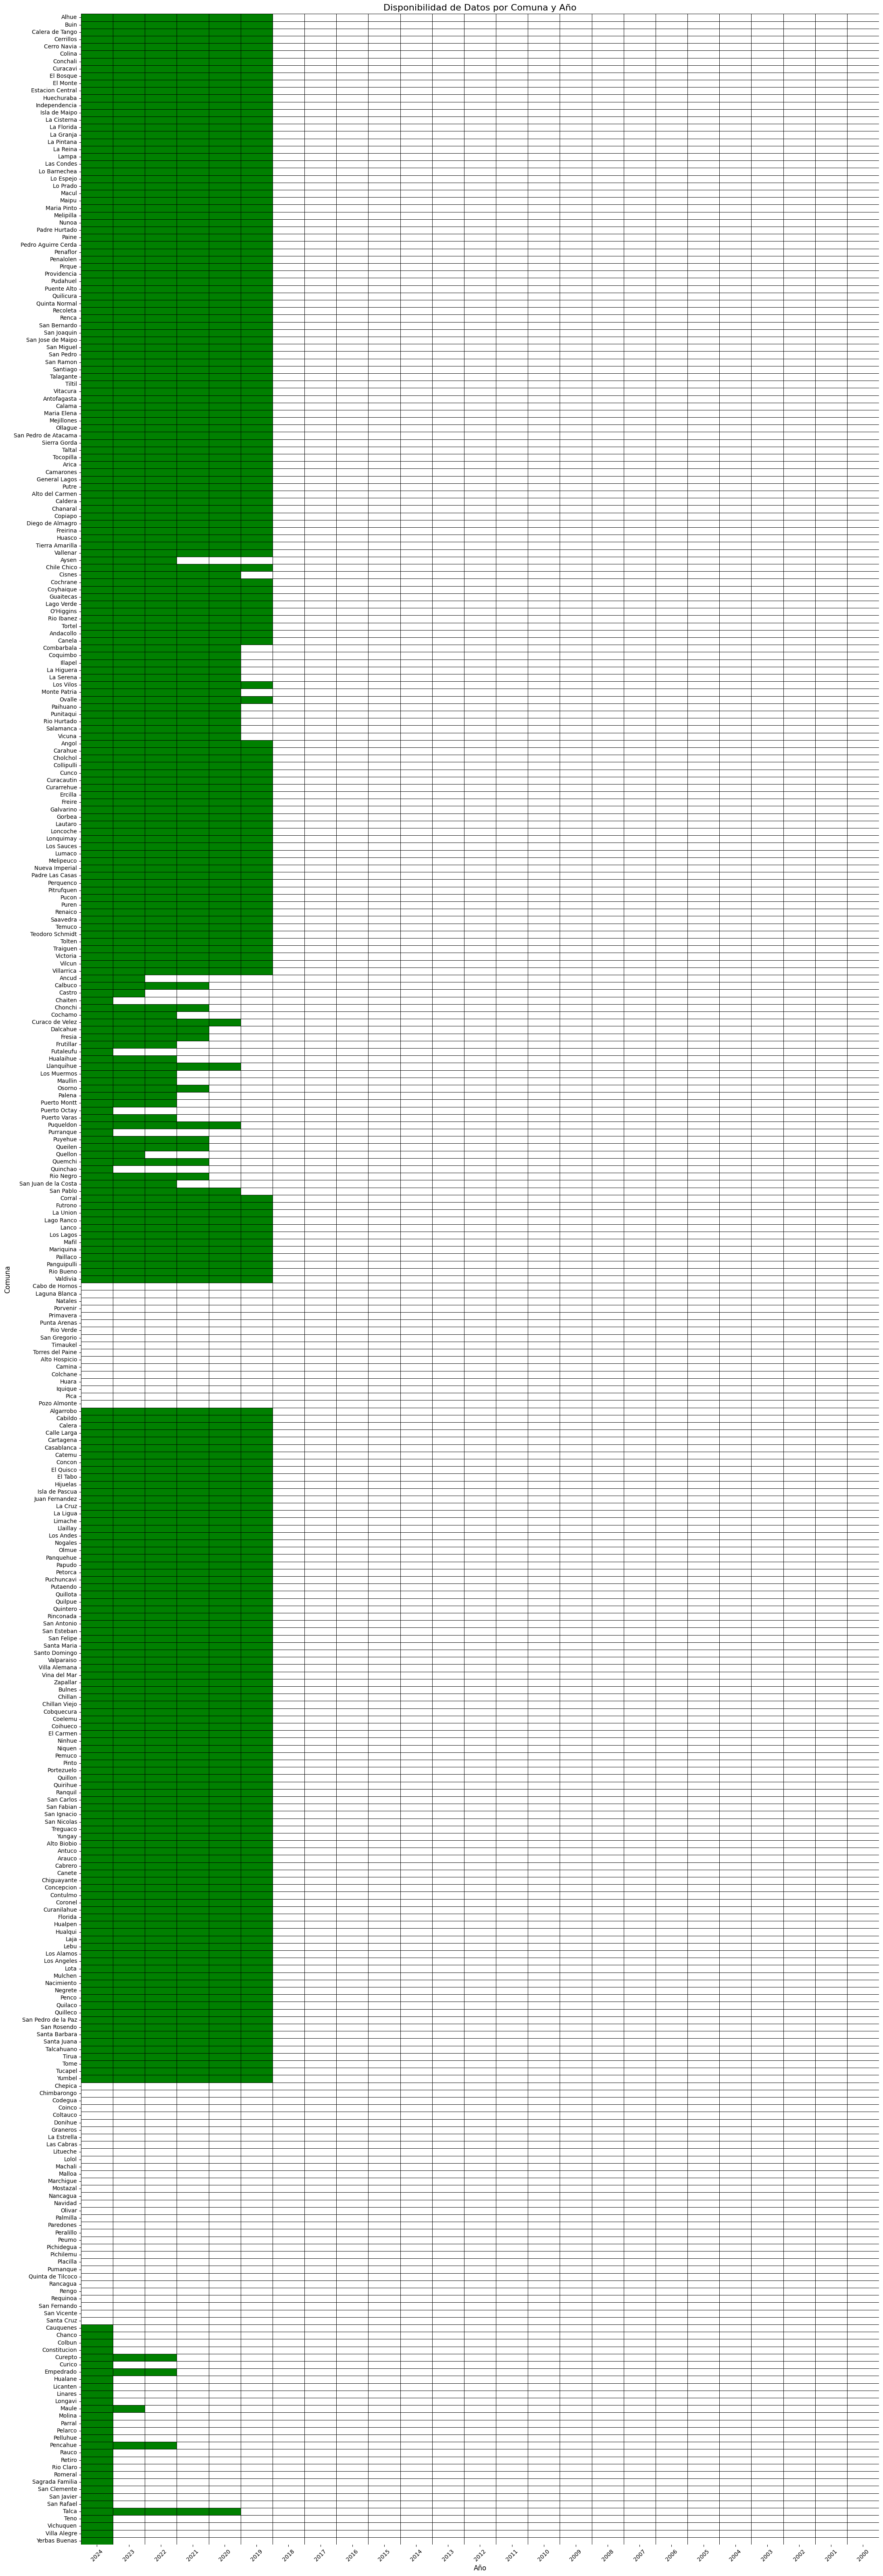

In [30]:
# Generar el DataFrame
df = generaDataFrame()

# Eliminar la columna 'Region'
df = df.drop(columns='Region')

# Establecer la comuna como índice
df.set_index('Comuna', inplace=True)

# Verificar que las columnas de años sean numéricas
year_columns = [str(year) for year in range(2024, 1999, -1)]
df[year_columns] = df[year_columns].apply(pd.to_numeric, errors='coerce')

# Crear el heatmap
plt.figure(figsize=(22, 64))  # Ajusta el tamaño de la figura según sea necesario
sns.heatmap(df, cmap=['white', 'green'], cbar=False, linewidths=0.5, linecolor='black')

# Añadir títulos y etiquetas
plt.title('Disponibilidad de Datos por Comuna y Año', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Comuna', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [22]:
df

,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,...,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
Comuna,,,,,,,,,,,,,,,,,,,,,
Alhue,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buin,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calera de Tango,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cerrillos,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cerro Navia,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Talca,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Teno,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vichuquen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def contar_archivos_en_bucket(bucket_name, carpeta):
    # Configurar el cliente de Google Cloud Storage
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)

    # Listar los blobs en la carpeta especificada dentro del bucket
    blobs = bucket.list_blobs(prefix=carpeta)

    # Contar el número de archivos (blobs)
    procesados = sum(1 for blob in blobs if not blob.name.endswith('/'))

    return procesados

In [31]:
bucket_name = 'tesis_data'
carpeta = 'comunas/'

procesados = contar_archivos_en_bucket(bucket_name, carpeta)
total_5= len(df)*5
total_24 = len(df)*24

print(f'Los últimos 5 años se han procesado {procesados} de {total_5}. Avance de {(procesados/total_5)*100:.2f}')
print(f'Los últimos 24 años se han procesado {procesados} de {total_24}. Avance de {(procesados/total_24)*100:.2f}')

Los últimos 5 años se han procesado 1546 de 1725. Avance de 89.62
Los últimos 24 años se han procesado 1546 de 8280. Avance de 18.67


In [ ]:
client = storage.Client()

# Inicializar una lista para almacenar los DataFrames
dataframes = []

# Obtener la referencia al bucket
bucket = client.get_bucket(bucket_name)

# Listar todos los archivos en la carpeta especificada dentro del bucket
blobs = bucket.list_blobs(prefix=carpeta)

# Recorrer todos los archivos en el bucket
for blob in blobs:
    if blob.name.endswith('.csv'):
        # Descargar el archivo CSV como un string
        csv_string = blob.download_as_string()

        # Leer el CSV en un DataFrame utilizando io.StringIO
        df = pd.read_csv(io.StringIO(csv_string.decode('utf-8')))

        # Añadir el DataFrame a la lista
        dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
df_unido = pd.concat(dataframes, ignore_index=True)

6

          Comuna                            Region fecha_desde fecha_hasta  \
0      Algarrobo              Región de Valparaíso  2019-01-01  2019-01-07   
1      Algarrobo              Región de Valparaíso  2019-01-08  2019-01-14   
2      Algarrobo              Región de Valparaíso  2019-01-15  2019-01-21   
3      Algarrobo              Región de Valparaíso  2019-01-22  2019-01-28   
4      Algarrobo              Región de Valparaíso  2019-01-29  2019-02-04   
...          ...                               ...         ...         ...   
79124      Ñuñoa  Región Metropolitana de Santiago  2024-12-02  2024-12-08   
79125      Ñuñoa  Región Metropolitana de Santiago  2024-12-09  2024-12-15   
79126      Ñuñoa  Región Metropolitana de Santiago  2024-12-16  2024-12-22   
79127      Ñuñoa  Región Metropolitana de Santiago  2024-12-23  2024-12-29   
79128      Ñuñoa  Región Metropolitana de Santiago  2024-12-30  2025-01-05   

       valor_medio_optical_depth_047  
0                       

In [ ]:
df_unido

,Comuna,Region,fecha_desde,fecha_hasta,valor_medio_optical_depth_047
0,Algarrobo,Región de Valparaíso,2019-01-01,2019-01-07,125.281266
1,Algarrobo,Región de Valparaíso,2019-01-08,2019-01-14,94.487922
2,Algarrobo,Región de Valparaíso,2019-01-15,2019-01-21,167.328483
3,Algarrobo,Región de Valparaíso,2019-01-22,2019-01-28,189.466314
4,Algarrobo,Región de Valparaíso,2019-01-29,2019-02-04,215.103330
...,...,...,...,...,...
79124,Ñuñoa,Región Metropolitana de Santiago,2024-12-02,2024-12-08,NaN
79125,Ñuñoa,Región Metropolitana de Santiago,2024-12-09,2024-12-15,NaN
79126,Ñuñoa,Región Metropolitana de Santiago,2024-12-16,2024-12-22,NaN
79127,Ñuñoa,Región Metropolitana de Santiago,2024-12-23,2024-12-29,NaN


In [19]:
df_unido['fecha_desde'] = pd.to_datetime(df_unido['fecha_desde'], errors='coerce')

fecha_limite = pd.Timestamp('2024-08-07')
df_filtrado = df_unido[df_unido['fecha_desde'] > fecha_limite]

df_filtrado

,Comuna,Region,fecha_desde,fecha_hasta,valor_medio_optical_depth_047
297,Algarrobo,Región de Valparaíso,2024-08-12,2024-08-18,NaN
298,Algarrobo,Región de Valparaíso,2024-08-19,2024-08-25,NaN
299,Algarrobo,Región de Valparaíso,2024-08-26,2024-09-01,NaN
300,Algarrobo,Región de Valparaíso,2024-09-02,2024-09-08,NaN
301,Algarrobo,Región de Valparaíso,2024-09-09,2024-09-15,NaN
...,...,...,...,...,...
79124,Ñuñoa,Región Metropolitana de Santiago,2024-12-02,2024-12-08,NaN
79125,Ñuñoa,Región Metropolitana de Santiago,2024-12-09,2024-12-15,NaN
79126,Ñuñoa,Región Metropolitana de Santiago,2024-12-16,2024-12-22,NaN
79127,Ñuñoa,Región Metropolitana de Santiago,2024-12-23,2024-12-29,NaN
